In [1]:
import ultranest as un
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../system')
import system

In [2]:
paramnames = [
    'sigma', 
    'rp', 
    'rm', 
    'u1', 
    'u2', 
    'ap', 
    'tp', 
    'ep', 
    'pp', 
    'wp', 
    'ip', 
    'am', 
    'tm', 
    'em', 
    'pm', 
    'om', 
    'wm', 
    'im', 
    'mm'
]

t = np.linspace(67.8, 68.8, 100)

ap = 1.0
t0p = 0.2
ep = 0.2
Pp = 365
wp = 0.0 * np.pi / 180
ip = 90.0 * np.pi / 180

am = 0.007
t0m = -1.2
em = 0.1
Pm = 3
Om = 0.0 * np.pi / 180
wm = 90 * np.pi / 180
im = 90.0 * np.pi / 180
mm = 0.01

rp = 0.05
rm = 0.03
u1 = 0.4
u2 = 0.5

sigma = 0.0001

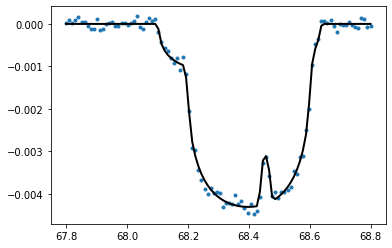

In [3]:
moon = system.moon(rm, am, t0m, em, Pm, Om, wm, im, mm)
planet = system.planet(rp, ap, t0p, ep, Pp, wp, ip)
star = system.star(u1, u2)

sys = system.system(star, planet, moon)
sys.compute(t, grad=True)

lctrue = sys.lightcurve()
y = lctrue + np.random.randn(len(t)) * sigma
plt.plot(t, y, '.')
plt.plot(t, lctrue, color='k', linewidth=2)

In [4]:
# define some prior transforms
from scipy.stats import norm, truncnorm
from types import SimpleNamespace 

uniform = lambda x, low, high: x * (high - low) + low
normal = lambda x, mu, sigma: norm.ppf(x, mu, sigma)
truncated_normal = lambda x, mu, sigma, low, high: truncnorm.ppf(x, low, high, mu, sigma)

def prior_transform(c):
    
    ap = uniform(c[0], 0.8, 1.2)
    tp = normal(c[1], 0.2, 0.1)
    pp = normal(c[2], 365, 0.1)
    wp = truncated_normal(c[3], 0.0, 0.001, -0.2, 0.2)
    ip = truncated_normal(c[4], np.pi/2, 0.001, 0.0, np.pi/2)
    
    am = uniform(c[5], 0.005, 0.01)
    tm = normal(c[6], -1.2, 0.1)
    pm = truncated_normal(c[7], 3.0, 0.1, 0.0, 10.0)
    om = truncated_normal(c[8], 0.0, 0.01, 0.0, 0.1)
    wm = truncated_normal(c[9], np.pi/2, 0.1, 0.0, np.pi)
    im = truncated_normal(c[10], np.pi/2, 0.1, 0.0, np.pi/2)
    mm = uniform(c[11], 0.005, 0.01)
    
    ep = normal(c[12], 0.2, 0.0001)
    em = uniform(c[13], 0.0, 1.0)
    
    q1 = c[14]
    q2 = c[15]
    u1 = 2 * np.sqrt(q1) * q2
    u2 = np.sqrt(q1) * (1 - 2 * q2)
    
    rp = truncated_normal(c[16], 0.05, 0.01, 0.15, 0.5)
    rm = truncated_normal(c[17], 0.03, 0.01, 0.0, 0.15)
    
    sigma = truncated_normal(c[18], 0.001, 0.01, 0.0, 0.1)
    
    #ap = 1.0
    #tp = 0.2
    #ep = 0.2
    #pp = 365
    #wp = 0.0 * np.pi / 180
    #ip = 90.0 * np.pi / 180

    #am = 0.007
    #tm = -1.2
    #em = 0.1
    #pm = 3
    #om = 0.0 * np.pi / 180
    #wm = 90 * np.pi / 180
    #im = 90.0 * np.pi / 180
    #mm = 0.01

    #rp = 0.05
    #rm = 0.03
    #u1 = 0.4
    #u2 = 0.5
    
    return [
        sigma, 
        rp, 
        rm, 
        u1, 
        u2, 
        ap, 
        tp, 
        ep, 
        pp, 
        wp, 
        ip, 
        am, 
        tm, 
        em, 
        pm, 
        om, 
        wm, 
        im, 
        mm
    ]

In [5]:
def make_model(args):
    sigma, rp, rm, u1, u2, ap, tp, ep, pp, wp, ip, am, tm, em, pm, om, wm, im, mm = args
    moon = system.moon(rm, am, tm, em, pm, om, wm, im, mm)
    planet = system.planet(rp, ap, tp, ep, pp, wp, ip)
    star = system.star(u1, u2)
    sys = system.system(star, planet, moon)
    sys.compute(t, grad=False)
    return sys.lightcurve()

def log_like(args):
    
    sigma, rp, rm, u1, u2, ap, tp, ep, pp, wp, ip, am, tm, em, pm, om, wm, im, mm = args
    moon = system.moon(rm, am, tm, em, pm, om, wm, im, mm)
    planet = system.planet(rp, ap, tp, ep, pp, wp, ip)
    star = system.star(u1, u2)
    sys = system.system(star, planet, moon)
    sys.compute(t, grad=False)
    return sys.loglike(y, sigma)

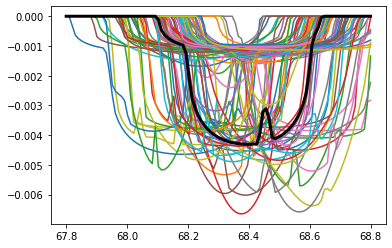

In [6]:
for _ in range(100):
    r = np.random.rand(len(paramnames))
    plt.plot(t, make_model(prior_transform(r)))
    #print(log_like(prior_transform(r)))
plt.plot(t, lctrue, color='k', linewidth=3)

In [7]:
sampler = un.ReactiveNestedSampler(paramnames, log_like, prior_transform)

In [8]:
result = sampler.run(min_num_live_points=50, 
                     dlogz=0.25, # desired accuracy on logz 
                     min_ess=50, # number of effective samples 
                     #update_interval_iter_fraction=0.2, # how often to update region
                     max_num_improvement_loops=1, # how many times to go back and improve
                    )

[ultranest] Sampling 50 live points from prior ...


[ultranest] Found 1 clusters, but only have 50 live points, want 80.=10/64 eff=71.4286% N=50 
[ultranest] Explored until L=6e+02  
[ultranest] Likelihood function evaluations: 65
[ultranest] parent value is -inf, so widening roots
[ultranest] Widening roots to 80 live points (have 50 already) ...
[ultranest] Sampling 30 live points from prior ...


/usr/local/lib/python3.8/site-packages/ultranest/integrator.py:1622: UserWarning: Sampling from region seems inefficient (0/40 accepted in iteration 2500). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


/usr/local/lib/python3.8/site-packages/ultranest/integrator.py:1921: RuntimeWarning: invalid value encountered in sqrt
  tregion.create_ellipsoid()


/usr/local/lib/python3.8/site-packages/ultranest/integrator.py:1921: RuntimeWarning: invalid value encountered in sqrt
  tregion.create_ellipsoid()


/usr/local/lib/python3.8/site-packages/ultranest/integrator.py:1921: RuntimeWarning: invalid value encountered in sqrt
  tregion.create_ellipsoid()


/usr/local/lib/python3.8/site-packages/ultranest/integrator.py:1921: RuntimeWarning: invalid value encountered in sqrt
  tregion.create_ellipsoid()


KeyboardInterrupt: 

In [ ]:
from ultranest.plot import cornerplot

In [ ]:
cornerplot(result)

In [ ]:
for i in np.random.randint(len(result['samples']), size=100):
    plt.plot(t, make_model(result['samples'][i]), color='k', alpha=0.3)